<h1 align="center">Sistema de Recuperação de Informações</h1>

<h2 align="center"> Lista de Exercícios 2 </h2>

<h3 align="center"> Gabriel Lima Novais</h3>

___

Todos os exercícios requerem uma implementação funcional do problema, no corpo do notebook. Para cada exercício consultas de teste devem ser propostas para demonstrar que a implementação atende aos requisitos do exercício.
As resposta devem ser enviadas como um notebook (.ipynb) para o professor.

### 1. Importando pacotes

In [88]:
import numpy as np
import pandas as pd
import os
import re
import whoosh
import nltk
import string
import matplotlib.pyplot as plt
import enchant

from nltk.corpus import machado, mac_morpho,stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer,PortugueseStemmer
from whoosh.index import create_in, open_dir
from whoosh.fields import *
from whoosh import qparser
from whoosh.qparser import QueryParser
from collections import defaultdict,Counter
from math import log
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models, similarities
from numpy.linalg import norm
from gensim import corpora, models, similarities
from string import punctuation


%matplotlib inline

### 2. Configurando Corpus

In [2]:
nltk.download('stopwords')
nltk.download('machado')
#Organizando os textos do Machado
textos = [machado.raw(id) for id in machado.fileids()]
tok_textos = [WordPunctTokenizer().tokenize(t.lower()) for t in textos]
len(set(tok_textos[0]))
# Gerando vocabulário de palavras únicas de todos os textos
vocab = set([])
for t in tok_textos:
    vocab = vocab.union(set(t))
vocab = map(lambda x:x.lower(),vocab)
vocab = list(set(vocab))
vocab[:3]
# Gerando coleção de textos
T = nltk.TextCollection(tok_textos)
print(str(len(tok_textos)) + ' textos na coleção')
print(str(len(vocab)) + ' palavras únicas na coleção')

[nltk_data] Downloading package stopwords to /home/novais/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package machado to /home/novais/nltk_data...
[nltk_data]   Package machado is already up-to-date!


246 textos na coleção
66169 palavras únicas na coleção


### Exercício 1: Similaridade por Cosseno.

Com base na metodologia apresentada na Prática 2, usando o corpus de Machado, Construa vetorizações, binárias, por frequência e por tf-idf. Compare a ordenação dos resultados para uma consulta qualquer, com pelo menos 3 palavras. Para a ordenação dos resultados, use o cosseno entre os vetores da consulta e dos documentos.

In [32]:
def freq(tok_textos,queryt):
    #Valores de sequência sobre a consulta:
    binary_matrix = np.zeros((len(tok_textos),len(queryt))) # Frequência binária
    tf_matrix = np.zeros((len(tok_textos),len(queryt))) # Frequência no texto
    tfidf_matrix = np.zeros((len(tok_textos),len(queryt))) # Frequência por tf_idf
    #Matrizes:
    for j, termo in enumerate(queryt):
        for i, texto in enumerate(tok_textos):
            tfidf_matrix[i,j] = T.tf_idf(termo,texto)
            tf_matrix[i,j] = T.tf(termo,texto)
            if tf_matrix[i,j] > 0:
                binary_matrix[i,j] = 1
    tfidfM = tfidf_matrix
    tfM = tf_matrix
    bM = binary_matrix
    return [bM,tfM,tfidfM]

In [6]:
def ordem(q,MN):
    return [np.dot(q,r) for r in MN]

In [7]:
def normalizaMatriz(matrix):
    aux = []
    for r in matrix:
        if np.linalg.norm(r) !=0:
            aux.append(r/np.linalg.norm(r))
        else:
            aux.append(np.zeros(len(r)))
    return np.array(aux)

In [8]:
def construct(qt,matrix):
    vet = np.array([T.tf_idf(w,qt) for w in qt])
    vet = vet/np.linalg.norm(vet)
    ans = ordem(vet,matrix)
    return ans

In [9]:
def filtering(v,tok):
    aux = filter(lambda x : x[0]!=0.0, zip(v,range(len(tok))))
    aux = sorted(aux, reverse=True)
    return aux 

In [74]:
def plotVector(tk,qt,matrix,h,w,docs):
    #Transformações:
    m = normalizaMatriz(matrix)
    vetor1 = construct(qt,m)
    vetor2 = filtering(vetor1,tk)
    #Configurações Iniciais:
    fig = plt.figure(figsize=(h,w))
    ax = plt.gca()
    vecs = [vetor1[:2]]
    #loop:
    for d in vetor2[:docs]:
        vecs.append(m[d[1]][:2])
        x,y = m[d[1]][:2]
        plt.text(x,y,'{}'.format(d[1]))
    U, V = zip(*vecs)
    x,y = np.zeros(docs+1), np.zeros(docs+1)
    plt.text(U[0],V[0],'consulta')
    #Configurações Finais:
    plt.grid()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('lamartine')
    ax.set_ylabel('elixir')
    ax.quiver(x,y,U,V,angles='xy',scale_units='xy', scale=1.0);
    return plt.show()

In [83]:
#Query:
query = "lamartine elixir harpa"
queryt = WordPunctTokenizer().tokenize(query.lower())

In [84]:
#Matrizes:
M = freq(tok_textos,queryt)

In [85]:
print("Binary: \n\n"+str(M[0][0:10]))
print('')
print("TF: \n\n"+str(M[1][0:10]))
print('')
print("TFIDF: \n\n"+str(M[2][0:10]))

Binary: 

[[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

TF: 

[[1.43837291e-05 2.87674583e-05 1.43837291e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.78846085e-05 0.00000000e+00 1.78846085e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

TFIDF: 

[[4.34449734e-05 9.51658288e-05 4.12277118e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.40191166e-05 0.00000000e+00 5.12621921e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.0

(0.9435141616147088, 0.72549778131188, 0.38636877110285245, 0.7253746092876421) (0.0, 0.5959486701225939, 0.8463373654036943, 0.0)


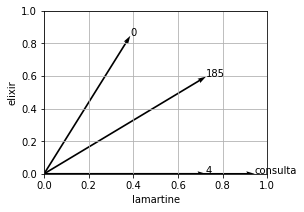

In [86]:
# Vetorização Binária
##plotVector(tok_textos,queryt,M[0],4,3,3)
# Vetorização tf
##plotVector(tok_textos,queryt,M[1],4,3,3)
# Vetorização tf_idf
plotVector(tok_textos,queryt,M[2],4,3,3)

### Exercício 2: Explorando o conceito de similaridade
Construa uma matriz de similaridade (cossenos entre vetores de frequência) entre todos os textos de machado. Construa um histograma com os valores de similaridade, excluindo os 0s e 1s. Interprete.

In [49]:
def palavrasUnicas(txt):
    vetor = TfidfVectorizer(min_df=1)
    tfidf = vetor.fit_transform(txt)
    matriz = (tfidf * tfidf.T).A
    plt.hist(matriz)          
    plt.title("Similaridade")
    plt.xlabel("Cos")
    plt.ylabel("Frequência")
    return plt.show

<function matplotlib.pyplot.show(*args, **kw)>

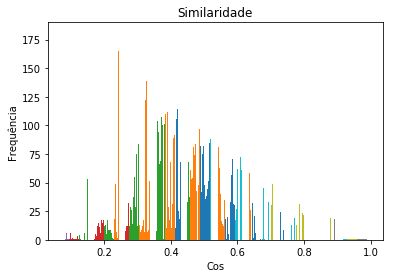

In [50]:
palavrasUnicas(textos)

###  Exercício 3: Usando o Gensim
Instale o Gensim, se ainda não o tiver. Seguindo o início deste tutorial: https://radimrehurek.com/gensim/tut2.html, construa um corpus usando as classes do Gensim, mas com os textos de Machado.

In [107]:
def frequenciaDict(txt):
    #Configurações iniciais:
    sw = stopwords.words('portuguese')+ list(punctuation)
    stemmer = PortugueseStemmer()
    #Incializando vetores:
    txtClean = []
    c = Counter([])
    #Loop:
    for texto in txt:
        aux = [stemmer.stem(token.strip(punctuation).lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in sw]
        c.update(aux)
        txtClean.append(aux)
    txtClean = [[token for token in t if c[token]>1] for t in txtClean]
    #Gerando dicionário:
    dicionario = corpora.Dictionary(txtClean)
    dicionario.save('vocabulario.dict')
    #Gerando as frequências:
    corpus = [dicionario.doc2bow(d) for d in txtClean]
    corpora.MmCorpus.serialize('machado.mm', corpus)
    return [txtClean,corpus,dicionario]

In [108]:
corpus = frequenciaDict(textos)[1]
corpus = corpus[0]
print(corpus[0:5])

[(0, 423), (1, 1), (2, 1), (3, 1), (4, 2)]


###  Exercício 4: Indexação Semântica Latente.
Ainda seguindo o tutorial citado no exercício anterior, ajuste um modelo LSI para os documentos de machado. Interprete os resultados.

In [119]:
def modelos(txt):
     # Construção do modelo TF-IDF
    mod_tfidf = models.TfidfModel(frequenciaDict(txt)[1])
    corpus_tfidf = mod_tfidf[frequenciaDict(txt)[1]]
    d = frequenciaDict(txt)[2]
    mod_lsi = models.LsiModel(corpus_tfidf, id2word=d, num_topics=300)
    corpus_lsi = mod_lsi[corpus_tfidf]
    return [corpus_lsi,mod_lsi]

In [120]:
model = modelos(textos)

In [122]:
model[0][0][:10]

[(0, 0.35961137847669294),
 (1, 0.23767862088702985),
 (2, 0.19475060305226297),
 (3, -0.009978592385489857),
 (4, 0.07295461286426617),
 (5, -0.15044692856725775),
 (6, 0.01710345347874277),
 (7, -0.238324001847356),
 (8, 0.16466105825324204),
 (9, -0.06661538679213616)]

In [127]:
model[1].print_topics(10)

[(0,
  '0.302*"\x97" + 0.109*"sr" + 0.094*"poet" + 0.085*"luís" + 0.065*"crític" + 0.065*"camil" + 0.064*"\x93" + 0.062*"vers" + 0.059*"d" + 0.059*"jos"'),
 (1,
  '0.385*"\x97" + -0.154*"sr" + -0.150*"crític" + 0.144*"luís" + -0.137*"poet" + -0.131*"dramát" + -0.120*"alenc" + 0.103*"camil" + -0.101*"autor" + -0.100*"poes"'),
 (2,
  '0.307*"luís" + -0.241*"henriquet" + 0.142*"daniel" + 0.138*"jorg" + 0.137*"marcelin" + 0.132*"tit" + 0.130*"carlot" + 0.129*"poet" + 0.128*"cecíl" + 0.127*"alves"'),
 (3,
  '0.797*"henriquet" + 0.308*"juliã" + 0.155*"renan" + 0.090*"fernandinh" + 0.081*"elis" + 0.081*"pimentel" + 0.081*"veig" + 0.069*"jorg" + 0.060*"dramát" + 0.058*"crític"'),
 (4,
  '0.566*"cecíl" + -0.434*"luís" + -0.185*"alves" + -0.145*"camil" + 0.121*"venânci" + -0.117*"albert" + 0.113*"carlot" + 0.111*"magalhã" + -0.110*"major" + 0.106*"tibúrci"'),
 (5,
  '0.388*"cecíl" + -0.291*"tit" + -0.203*"daniel" + -0.157*"poet" + -0.127*"emíl" + 0.120*"jorg" + 0.101*"dramát" + -0.095*"vers" + -

<p align="center">Podemos observar que para cada tupla apresentada acima cada palavra possui um nível de correlação com outras palavras do corpus. Ou seja, para a palvra de índice 9 , temos que os termos "camil" e "carlot" apresentam em módulo uma relação forte, mas em termos absolutos tais relações são em sentidos contrários. A existência de símbolos e outros caracteres que não representam radicais de palavras ou sentido na língua podem mostrar a necessidade de uma limpeza melhor no corpus.</p>

#### FIM